In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
from pathlib import Path 

In [2]:
# Dataset
DATASET_DIR = './multi-cancer'
CANCER_TYPE = "Brain Cancer"

# Image
H, W = 224, 224
MEAN = torch.tensor([0.1541, 0.1541, 0.1541])
STD = torch.tensor([0.1642, 0.1642, 0.1642])

# Training
BATCH_SIZE = 32

TRAIN_PHASE1 = False
TRAIN_PHASE2 = True
TRAIN_PHASE3 = True

PHASE1_EPOCHS = 10
PHASE2_EPOCHS = 20
PHASE3_EPOCHS = 5

PHASE1_PATIENCE = 3
PHASE2_PATIENCE = 5

CRITERION = nn.CrossEntropyLoss()

PHASE1_LR = 1e-3
PHASE2_LR = 1e-4
PHASE3_LR = 1e-5

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
cancer_dir = os.path.join(DATASET_DIR, CANCER_TYPE)
class_names = sorted([d for d in os.listdir(cancer_dir) 
                      if os.path.isdir(os.path.join(cancer_dir, d))])
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

print("Classes:", class_names)
print("Class to index:", class_to_idx)

image_paths = []
image_labels = []
class_counts = {cls_name: 0 for cls_name in class_names}

for class_name in class_names:
    class_dir = os.path.join(cancer_dir, class_name)
    for filename in os.listdir(class_dir):
        path = os.path.join(class_dir, filename)
        if os.path.isfile(path):
            image_paths.append(path)
            image_labels.append(class_to_idx[class_name])
            class_counts[class_name] += 1

Classes: ['brain_glioma', 'brain_menin', 'brain_tumor']
Class to index: {'brain_glioma': 0, 'brain_menin': 1, 'brain_tumor': 2}


In [6]:
# Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')
print("Total image count:", len(image_paths))
print("\nClass distribution:")
for cls_name, count in class_counts.items():
    print(f"  {cls_name}: {count}")
print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['./multi-cancer\\Brain Cancer\\brain_tumor\\brain_tumor_3782.jpg', './multi-cancer\\Brain Cancer\\brain_tumor\\brain_tumor_2859.jpg', './multi-cancer\\Brain Cancer\\brain_glioma\\brain_glioma_2900.jpg', './multi-cancer\\Brain Cancer\\brain_tumor\\brain_tumor_2130.jpg', './multi-cancer\\Brain Cancer\\brain_glioma\\brain_glioma_4491.jpg'] 

[2, 2, 0, 2, 0] 

Total image count: 15000

Class distribution:
  brain_glioma: 5000
  brain_menin: 5000
  brain_tumor: 5000
Image size: (512, 512)
Image mode: RGB


In [7]:
#train, val, test = 70%, 15%, 15%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print("Training size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Testing size:", len(test_paths))

Training size: 10500
Validation size: 2250
Testing size: 2250


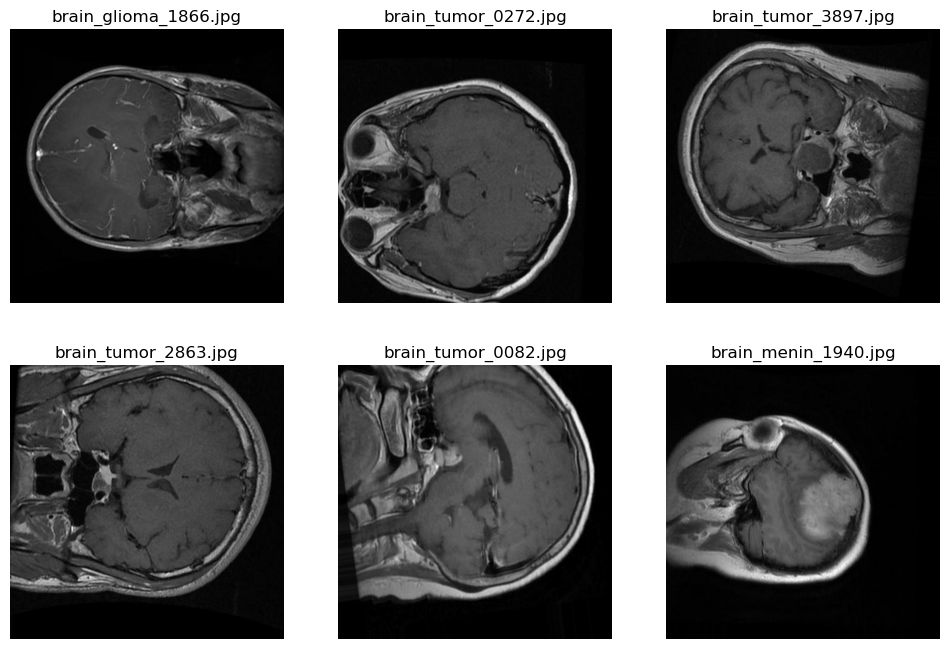

In [8]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [9]:
# # Calculate Mean and Standard Deviation of the training set
# transform = transforms.Compose([
#     transforms.Resize((H, W)),
#     transforms.ToTensor()
# ])

# mean = 0.
# std = 0.
# n = 0

# for path in tqdm(train_paths):
#     img = Image.open(path).convert('RGB')
#     img = transform(img)  # shape: [3, H, W]
#     mean += img.mean(dim=[1,2])
#     std += img.std(dim=[1,2])
#     n += 1

# mean /= n
# std /= n

# print("Mean:", mean)
# print("Std:", std)

In [10]:
#Data augmentation 
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
]) 

In [11]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# For train_loader, val_loader and test_loader
# There are approximately len({}_paths) / BATCH_SIZE batches in total
# Each batch has a shape of [BATCH_SIZE, 3, H, W]
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Training", leave=False)

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

        current_loss = total_loss / total_samples
        current_acc = total_correct / total_samples
        loop.set_postfix(loss=current_loss, acc=current_acc)

    return total_loss / total_samples, total_correct / total_samples

In [13]:
@torch.no_grad()
def eval_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Validating", leave=False)

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

        current_loss = total_loss / total_samples
        current_acc = total_correct / total_samples
        loop.set_postfix(loss=current_loss, acc=current_acc)

    return total_loss / total_samples, total_correct / total_samples


In [14]:
def save_checkpoint(model, optimizer, epoch, val_acc, train_losses, val_losses, save_path):
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "val_acc": val_acc,
        "train_losses": train_losses,
        "val_losses": val_losses
    }, save_path)

    print(f"[Checkpoint Saved] epoch={epoch}, val_acc={val_acc:.4f} → {save_path}")

def load_checkpoint(model, optimizer, path, device):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No checkpoint found at '{path}'")

    ckpt = torch.load(path, map_location=device)

    model.load_state_dict(ckpt["model_state_dict"])

    if optimizer is not None:
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])

    start_epoch = ckpt.get("epoch", 0)
    best_val_acc = ckpt.get("val_acc", 0.0)

    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])

    print(f"[Checkpoint Loaded] epoch={start_epoch}, best_val_acc={best_val_acc:.4f}")
    return model, optimizer, start_epoch, best_val_acc, train_losses, val_losses

In [15]:
@torch.no_grad()
def evaluate_on_test(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = (all_preds == all_labels).mean()
    print(f"\nTest Accuracy: {acc:.4f}")

    if class_names is None:
        class_names = ["normal", "SCC"]

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Set)")
    plt.tight_layout()
    plt.show()

### Phase 1: Train with frozen backbone

In [16]:
NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES) # type: ignore

for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=PHASE1_LR, weight_decay=1e-4)

Number of classes: 3


In [17]:
best_val_acc = 0.0

checkpoint_dir = Path('checkpoints') / CANCER_TYPE.lower().replace(" ", "_") / 'phase1'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_model.pth"

if TRAIN_PHASE1:
    train_losses = []
    val_losses = []
    start_epoch = 0
    patience_counter = 0

    for epoch in range(PHASE1_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, CRITERION, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, optimizer, CRITERION, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"[Epoch {epoch+1}/{PHASE1_EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(model, optimizer, epoch + 1, best_val_acc, train_losses, val_losses, checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PHASE1_PATIENCE:
                print("Early stopping triggered.")
                break
else:
    model, optimizer, start_epoch, best_val_acc, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

[Checkpoint Loaded] epoch=6, best_val_acc=0.9404


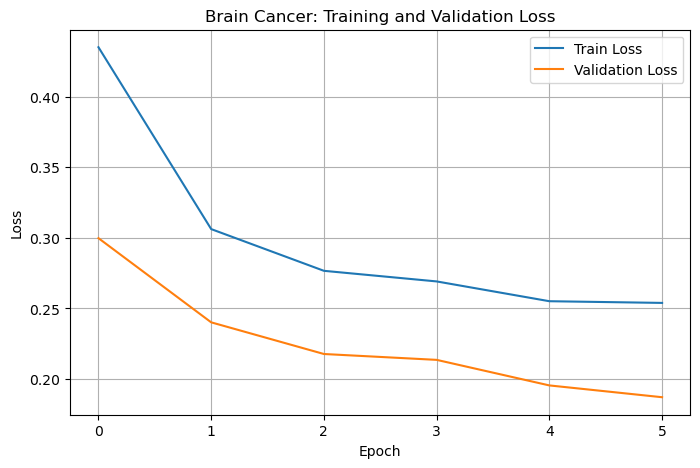

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(CANCER_TYPE + ': Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Phase 2: Fine-tune the entire model

In [19]:
for param in model.features.parameters():
    param.requires_grad = False


num_blocks = len(model.features)
for idx in range(num_blocks - 3, num_blocks):
    for param in model.features[idx].parameters():
        param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=PHASE2_LR, weight_decay=1e-4)

In [20]:
checkpoint_dir = Path('checkpoints') / CANCER_TYPE.lower().replace(" ", "_") / 'phase2'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_model.pth"

if TRAIN_PHASE2:
    train_losses = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(PHASE2_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, CRITERION, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, CRITERION, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"[Phase2 Epoch {epoch+1}/{PHASE2_EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(model, optimizer, epoch + 1, best_val_acc, train_losses, val_losses, checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PHASE2_PATIENCE:
                print("Early stopping triggered.")
                break
else:
    model, optimizer, start_epoch, best_val_acc, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

[Phase2 Epoch 1/20] Train Loss: 0.1612, Acc: 0.9400 | Val Loss: 0.0622, Acc: 0.9791
[Checkpoint Saved] epoch=1, val_acc=0.9791 → checkpoints\brain_cancer\phase2\best_model.pth


[Phase2 Epoch 2/20] Train Loss: 0.0876, Acc: 0.9690 | Val Loss: 0.0364, Acc: 0.9898
[Checkpoint Saved] epoch=2, val_acc=0.9898 → checkpoints\brain_cancer\phase2\best_model.pth


[Phase2 Epoch 3/20] Train Loss: 0.0498, Acc: 0.9817 | Val Loss: 0.0489, Acc: 0.9836


[Phase2 Epoch 4/20] Train Loss: 0.0445, Acc: 0.9841 | Val Loss: 0.0192, Acc: 0.9951
[Checkpoint Saved] epoch=4, val_acc=0.9951 → checkpoints\brain_cancer\phase2\best_model.pth


[Phase2 Epoch 5/20] Train Loss: 0.0364, Acc: 0.9874 | Val Loss: 0.0129, Acc: 0.9956
[Checkpoint Saved] epoch=5, val_acc=0.9956 → checkpoints\brain_cancer\phase2\best_model.pth


[Phase2 Epoch 6/20] Train Loss: 0.0260, Acc: 0.9908 | Val Loss: 0.0049, Acc: 0.9991
[Checkpoint Saved] epoch=6, val_acc=0.9991 → checkpoints\brain_cancer\phase2\best_model.pth


[Phase2 Epoch 7/20] Train Loss: 0.0265, Acc: 0.9905 | Val Loss: 0.0059, Acc: 0.9987


[Phase2 Epoch 8/20] Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0052, Acc: 0.9982


[Phase2 Epoch 9/20] Train Loss: 0.0214, Acc: 0.9933 | Val Loss: 0.0030, Acc: 0.9996
[Checkpoint Saved] epoch=9, val_acc=0.9996 → checkpoints\brain_cancer\phase2\best_model.pth


[Phase2 Epoch 10/20] Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0013, Acc: 0.9996


[Phase2 Epoch 11/20] Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.0013, Acc: 1.0000
[Checkpoint Saved] epoch=11, val_acc=1.0000 → checkpoints\brain_cancer\phase2\best_model.pth


[Phase2 Epoch 12/20] Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0054, Acc: 0.9973


[Phase2 Epoch 13/20] Train Loss: 0.0135, Acc: 0.9963 | Val Loss: 0.0017, Acc: 0.9996


[Phase2 Epoch 14/20] Train Loss: 0.0113, Acc: 0.9956 | Val Loss: 0.0056, Acc: 0.9991


[Phase2 Epoch 15/20] Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0068, Acc: 0.9960


[Phase2 Epoch 16/20] Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0030, Acc: 0.9987
Early stopping triggered.


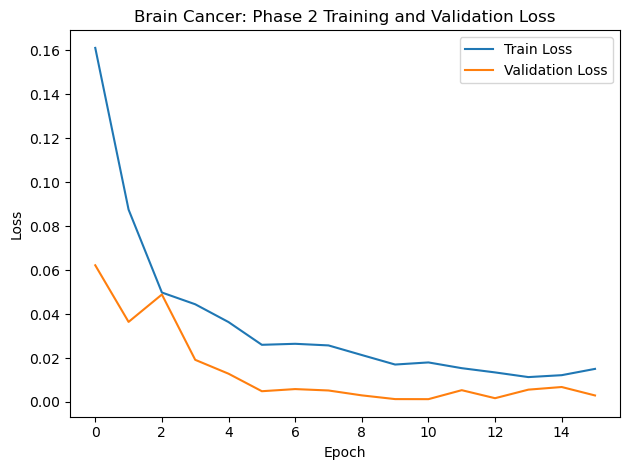

In [21]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(CANCER_TYPE + ': Phase 2 Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

### Phase 3: Final training with combined data (train + val)

In [22]:
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
for param in model.parameters():
    param.requires_grad = True

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=PHASE3_LR, weight_decay=1e-4)

In [24]:
checkpoint_dir = Path('checkpoints') / CANCER_TYPE.lower().replace(" ", "_") / 'phase3'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_model.pth"

if TRAIN_PHASE3:
    combined_losses = []
    test_losses = []
    test_accs = []
    best_test_acc = 0.0

    for epoch in range(PHASE3_EPOCHS):
        combined_loss, combined_acc = train_one_epoch(model, combined_loader, optimizer, CRITERION, device)
        test_loss, test_acc = eval_one_epoch(model, test_loader, CRITERION, device)

        combined_losses.append(combined_loss)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f"[Phase3 Epoch {epoch+1}/{PHASE3_EPOCHS}] "
              f"Train Loss: {combined_loss:.4f}, Acc: {combined_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

    save_checkpoint(model, optimizer, epoch + 1, best_test_acc, combined_losses, test_losses, checkpoint_path)
else:
    model, optimizer, start_epoch, best_val_acc, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

[Phase3 Epoch 1/5] Train Loss: 0.0068, Acc: 0.9980 | Test Loss: 0.0014, Acc: 0.9991


[Phase3 Epoch 2/5] Train Loss: 0.0060, Acc: 0.9980 | Test Loss: 0.0010, Acc: 0.9996


[Phase3 Epoch 3/5] Train Loss: 0.0051, Acc: 0.9982 | Test Loss: 0.0009, Acc: 0.9996


[Phase3 Epoch 4/5] Train Loss: 0.0054, Acc: 0.9985 | Test Loss: 0.0007, Acc: 0.9996


[Phase3 Epoch 5/5] Train Loss: 0.0033, Acc: 0.9991 | Test Loss: 0.0007, Acc: 0.9996
[Checkpoint Saved] epoch=5, val_acc=0.0000 → checkpoints\brain_cancer\phase3\best_model.pth


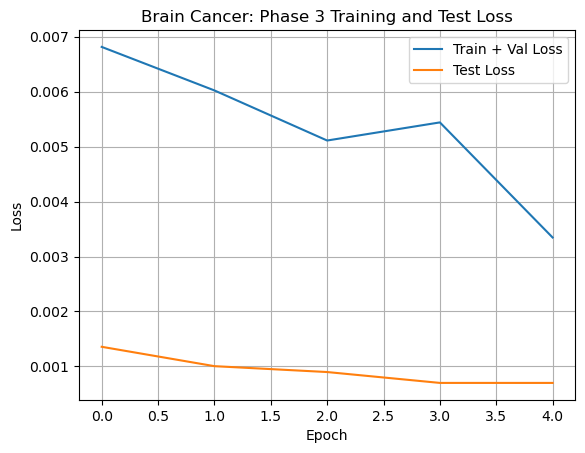

In [27]:
plt.plot(combined_losses, label='Train + Val Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(CANCER_TYPE + ': Phase 3 Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation

Class names: ['brain_glioma', 'brain_menin', 'brain_tumor']


Testing: 100%|██████████| 71/71 [00:12<00:00,  5.49it/s]



Test Accuracy: 0.9996

Classification Report:
              precision    recall  f1-score   support

brain_glioma       1.00      1.00      1.00       750
 brain_menin       1.00      1.00      1.00       750
 brain_tumor       1.00      1.00      1.00       750

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



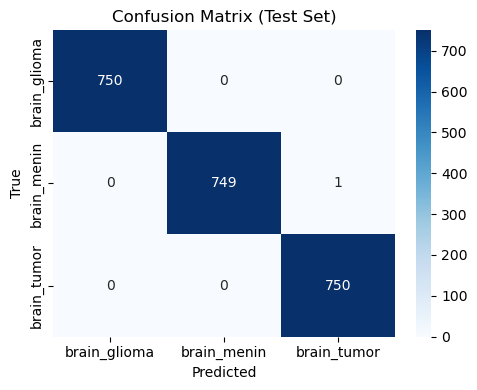

In [26]:
print("Class names:", class_names)
evaluate_on_test(model, test_loader, device, class_names=class_names)